This notebook provides the classification results for the building level analysis and classification.

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

% matplotlib inline

plt.rcParams['figure.figsize'] = 12, 8

## Building Level Classification

In [3]:
data_binary = pd.read_csv('data/building_level_data.csv').set_index('Unnamed: 0')

print data_binary.columns
print data_binary.shape

binarized_bld_type_dict = {'Monasteries':1, 'Mosques':0}
data_binary['bld_type_binary'] = data_binary['bld_type'].apply(lambda x: binarized_bld_type_dict[x])
col_data = [col for col in data_binary.columns if col != 'bld_type' and 'isovist' not in col]
data = data_binary[col_data]

print data.head(5)
print 'Proportion of Monasteries:', sum(data['bld_type_binary'])/float(data.shape[0])

Index([u'n_1', u'avg_isovistArea_1', u'avg_area_1', u'n_2',
       u'avg_isovistArea_2', u'avg_area_2', u'n_3-4', u'avg_isovistArea_3-4',
       u'avg_area_3-4', u'n_5+', u'avg_isovistArea_5+', u'avg_area_5+',
       u'bld_type'],
      dtype='object')
(39, 13)
             n_1  avg_area_1   n_2  avg_area_2  n_3-4  avg_area_3-4  n_5+  \
Unnamed: 0                                                                  
0           16.0   13.750000  13.0  450.846154    2.0     23.000000   5.0   
1           64.0   44.578125  16.0  106.375000    3.0     30.000000  12.0   
2           42.0    5.857143  54.0   16.388889   17.0     41.941176  17.0   
3           29.0   24.310345  36.0   27.638889    6.0     46.333333   4.0   
4            3.0  743.000000   0.0    0.000000    1.0   1207.000000   0.0   

            avg_area_5+  bld_type_binary  
Unnamed: 0                                
0            585.800000                0  
1           3323.833333                0  
2           3438.529412   

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import LeaveOneOut

model_fitting_dict_binary = {
    'Nearest Neighbours' : {
        'model': KNeighborsClassifier,
        'random_grid': {'n_neighbors': range(1,20)},
        'default': {'n_neighbors': 5},
        'optimize': False,
        'scale': True,
        'n_iter': 19
    },
    'Random Forest' : {
        'model': RandomForestClassifier,
        'random_grid': {'bootstrap': [True, False],
                         'max_depth': [10, 30, 50, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 350, 500, 1000]},
        'default': {'n_estimators': 100},
        'optimize': False,
        'scale': True,
        'n_iter': 100
    },
    'Logistic Regression' : {
        'model': LogisticRegression,
        'random_grid': None,
        'default': {'multi_class':'ovr', 'solver':'saga', 'max_iter':1000},
        'optimize': False,
        'scale': True
    },
    'Logistic Regression - L1 Penalty' : {
        'model': LogisticRegression,
        'random_grid': None,
        'default': {'multi_class':'ovr', 'solver':'saga', 'max_iter':1000, 'penalty':'l1'},
        'optimize': False,
        'scale': True
    },
    'Gradient Boosted Trees' : {
        'model': XGBClassifier,
        'random_grid': {
                        'min_child_weight': [1, 5, 10, 20],
                        'gamma': [0.5, 1, 1.5, 2, 5],
                        'subsample': [0.6, 0.8, 1.0],
                        'colsample_bytree': [0.6, 0.8, 1.0],
                        'max_depth': [10, 50, 100, 200, 400]
                        },
        'default': {'max_depth': 10, 'eta':0.3},
        'optimize': False,
        'scale': True,
        'n_iter': 100
    }
}

In [37]:
## Functions for classifications 

def merge_two_dicts(dict1, dict2):
    z = dict1.copy()  
    z.update(dict2) 
    return z

def splitOutcomeFunction(df, ycol=None):
    '''
    df is a pandas dataframe.
    '''

    if not isinstance(df, pd.DataFrame):
        raise ValueError('df is expected to be a pd.DataFrame,'
                         'it currently is' % (type(df)))

    if not ycol:
        ycol = df.columns[-1]

    col_sel = [x for x in df.columns if x != ycol]
    full_mat = df[col_sel]
    outcome_mat = df[ycol]

    return full_mat.as_matrix(), outcome_mat.as_matrix()

def fitting_model_from_dict(data, model_dict, outcome_col='bld_type_binary', outcome_label = [0,1], 
                            opt_metric='accuracy', optimize_flag=False):
    
    scaler = StandardScaler()
    X_mat, y_vec = splitOutcomeFunction(df=data, ycol=outcome_col)
    X_mat_scaled = scaler.fit_transform(X_mat)
    out_list = []
    
    for model_name, model_value in model_dict.iteritems():
        out_model = []
        print 'Working on %s'%(model_name)
        
        # Fitting the model as is first
        y_test_loo = []
        y_predict_loo = []
        loo = LeaveOneOut()
        for train_index, test_index in loo.split(X_mat):
            X_train, X_test = X_mat[train_index], X_mat[test_index]
            y_train, y_test = y_vec[train_index], y_vec[test_index]
            
            if model_value['default']:
                model = model_value['model'](**model_value['default'])
            else:
                model = model_value['model']()
            
            model.fit(X_train, y_train)
            y_predict_temp = model.predict(X_test)
            y_test_loo.append(y_test[0])
            y_predict_loo.append(y_predict_temp[0])
        
        y_predict_dict = Counter(zip(y_test_loo, y_predict_loo))
        out_model.append(model_name)
        for class_label in outcome_label:
            out_model.append(y_predict_dict[(class_label, class_label)]/float(sum(y_vec==class_label)))
        sum_correct = 0
        for class_label in outcome_label:
            sum_correct += y_predict_dict[(class_label, class_label)]
        out_model.append(sum_correct/float(len(y_vec)))
        out_list.append(out_model)    
            
        
        
        # Fitting the model scaled as necessary
        if model_value['scale']:
            out_model = []
                
            y_test_loo = []
            y_predict_loo = []
            loo = LeaveOneOut()
            for train_index, test_index in loo.split(X_mat_scaled):
                X_train, X_test = X_mat_scaled[train_index], X_mat_scaled[test_index]
                y_train, y_test = y_vec[train_index], y_vec[test_index]

                if model_value['default']:
                    model = model_value['model'](**model_value['default'])
                else:
                    model = model_value['model']()
                model.fit(X_train, y_train)
                y_predict_temp = model.predict(X_test)
                y_test_loo.append(y_test[0])
                y_predict_loo.append(y_predict_temp[0])
                
            y_predict_dict = Counter(zip(y_test_loo, y_predict_loo))
            out_model.append(model_name +' (Scaled)')
            for class_label in outcome_label:
                out_model.append(y_predict_dict[(class_label, class_label)]/float(sum(y_vec==class_label)))
            
            sum_correct = 0
            for class_label in outcome_label:
                sum_correct += y_predict_dict[(class_label, class_label)]
            out_model.append(sum_correct/float(len(y_vec)))
            out_list.append(out_model)
            
        # Optimize the model if necessary    
        if model_value['optimize'] and optimize_flag:
            out_model = []
            print 'Optimizing %s'%(model_name)
            
            if model_value['default']:
                model = model_value['model'](**model_value['default'])
            else:
                model = model_value['model']()
                
            print model_value
            
            random_grid = model_value['random_grid']
            random_opt = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid,
                               n_iter = model_value['n_iter'],
                               cv = 3, 
                               verbose=1, 
                               random_state=42, 
                               n_jobs = -1,
                               scoring = opt_metric)
            
            random_opt.fit(X_train, y_train)
            
            if model_value['default']:
                final_model_params_dict = merge_two_dicts(model_value['default'], random_opt.best_params_)
            else:
                final_model_params_dict = random_opt.best_params_
                
            y_test_loo = []
            y_predict_loo = []
            loo = LeaveOneOut()
            for train_index, test_index in loo.split(X_mat):
                X_train, X_test = X_mat[train_index], X_mat[test_index]
                y_train, y_test = y_vec[train_index], y_vec[test_index]
                
                model = model_value['model'](**final_model_params_dict)
                model.fit(X_train, y_train)
                y_predict_temp = model.predict(X_test)
                y_test_loo.append(y_test[0])
                y_predict_loo.append(y_predict_temp[0])
            
            
            y_predict_dict = Counter(zip(y_test_loo, y_predict_loo))
            out_model.append(model_name+' (Optimized)')
            for class_label in outcome_label:
                out_model.append(y_predict_dict[(class_label, class_label)]/float(sum(y_vec==class_label)))
            sum_correct = 0
            for class_label in outcome_label:
                sum_correct += y_predict_dict[(class_label, class_label)]
            out_model.append(sum_correct/float(len(y_vec)))
            out_list.append(out_model)
            
    return out_list


output_list_models_binary= fitting_model_from_dict(data=data, model_dict=model_fitting_dict_binary, outcome_col='bld_type_binary',
                        outcome_label = [0,1], opt_metric='accuracy', optimize_flag=False)

Working on Nearest Neighbours
Working on Logistic Regression - L1 Penalty
Working on Random Forest
Working on Logistic Regression
Working on Gradient Boosted Trees


In [5]:
## Saving the results as pickle file

from datetime import datetime

filename_out = 'processed_dict/output_list_results_binary_buildinglevel_%s.pkl'%(datetime.strftime(datetime.today(), format='%Y-%m-%d'))
pickle.dump(output_list_models_binary, open(filename_out, 'wb'))

In [38]:
## Importing the results - Uncomment if fresh run was done
#filename_out = 'processed_dict/output_list_results_binary_buildinglevel_2018-12-23.pkl'
#output_list_models_binary = pickle.load(open(filename_out, 'rb'))

random_class_acc = round(sum(data['bld_type_binary']==0)/float(data.shape[0])*100, 2)
for line in output_list_models_binary:
    model_name, class0_acc, class1_acc, total_acc = line
    print model_name, round(total_acc*100, 2), round(((round(total_acc*100, 2) - random_class_acc)/random_class_acc) * 100,2)

Nearest Neighbours 64.1 25.0
Nearest Neighbours (Scaled) 71.79 40.0
Logistic Regression - L1 Penalty 41.03 -19.99
Logistic Regression - L1 Penalty (Scaled) 61.54 20.01
Random Forest 69.23 35.0
Random Forest (Scaled) 69.23 35.0
Logistic Regression 41.03 -19.99
Logistic Regression (Scaled) 58.97 15.0
Gradient Boosted Trees 71.79 40.0
Gradient Boosted Trees (Scaled) 71.79 40.0


## Investigating Best Performing - Random Forest/XGBoost

In [7]:
import xgboost as xgb
import warnings

def partial_dependency(bst, X, y, f_id, n_grid = 100):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    Function taken from https://www.kaggle.com/chalkalan/xgboost-tutorial-var-imp-partial-dependence
    """

    X_temp = X.copy()

    grid = np.linspace(np.percentile(X_temp[:, f_id], 0.1),
                       np.percentile(X_temp[:, f_id], 99.5),
                       n_grid)
    y_pred = np.zeros(len(grid))

    for i, val in enumerate(grid):

        X_temp[:, f_id] = val

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y_pred[i] = np.average(bst.predict(X_temp))

    return grid, y_pred

In [8]:
from collections import defaultdict

def flatten_lol(lol):
    return [el for sublist in lol for el in sublist]

best_model_dict = {
    'Gradient Boosted Trees' : {
        'model': XGBClassifier,
        'random_grid': {
                        'min_child_weight': [1, 5, 10, 20],
                        'gamma': [0.5, 1, 1.5, 2, 5],
                        'subsample': [0.6, 0.8, 1.0],
                        'colsample_bytree': [0.6, 0.8, 1.0],
                        'max_depth': [10, 50, 100, 200, 400]
                        },
        'default': {'max_depth': 10, 'eta':0.3},
        'optimize': False,
        'scale': False,
        'n_iter': 100
    }
}

model_value = best_model_dict['Gradient Boosted Trees']
scaler = StandardScaler()
X_mat, y_vec = splitOutcomeFunction(df=data, ycol='bld_type_binary')

if model_value['scale']:
    X_mat = scaler.fit_transform(X_mat)

feature_vec = data.columns[:-1]
feature_importance_data = []
feature_dep_plot_dict = defaultdict(lambda:{'value':[], 'grid':[]})

loo = LeaveOneOut()
iteration = 1
for train_index, test_index in loo.split(X_mat):
    X_train, X_test = X_mat[train_index], X_mat[test_index]
    y_train, y_test = y_vec[train_index], y_vec[test_index]

    if model_value['default']:
        model = model_value['model'](**model_value['default'])
    else:
        model = model_value['model']()

    model.fit(X_train, y_train)
    feature_importance_data.append(model.feature_importances_)
    
    for feat_idx, feature in enumerate(feature_vec):
        grid, y_pred = partial_dependency(bst=model, X=X_train, y=y_train, f_id = feat_idx)
        feature_dep_plot_dict[feature]['grid'].append(grid)
        feature_dep_plot_dict[feature]['value'].append(y_pred)
    
    print 'Iteration %s Done' % (iteration)
    iteration += 1

Iteration 1 Done
Iteration 2 Done
Iteration 3 Done
Iteration 4 Done
Iteration 5 Done
Iteration 6 Done
Iteration 7 Done
Iteration 8 Done
Iteration 9 Done
Iteration 10 Done
Iteration 11 Done
Iteration 12 Done
Iteration 13 Done
Iteration 14 Done
Iteration 15 Done
Iteration 16 Done
Iteration 17 Done
Iteration 18 Done
Iteration 19 Done
Iteration 20 Done
Iteration 21 Done
Iteration 22 Done
Iteration 23 Done
Iteration 24 Done
Iteration 25 Done
Iteration 26 Done
Iteration 27 Done
Iteration 28 Done
Iteration 29 Done
Iteration 30 Done
Iteration 31 Done
Iteration 32 Done
Iteration 33 Done
Iteration 34 Done
Iteration 35 Done
Iteration 36 Done
Iteration 37 Done
Iteration 38 Done
Iteration 39 Done


In [9]:
feature_imp_df = pd.DataFrame.from_records(data=feature_importance_data, columns=feature_vec)
print feature_imp_df.head(2)

for feature, values in feature_dep_plot_dict.iteritems():
    
    if not isinstance(values['grid'][0], float):
        values['grid'] = flatten_lol(values['grid'])
        values['value'] = flatten_lol(values['value'])
    print feature, len(values['grid']), len(values['value'])

        n_1  avg_isovistArea_1  avg_area_1       n_2  avg_isovistArea_2  \
0  0.295566           0.093596    0.059113  0.009852           0.004926   
1  0.263158           0.076555    0.066986  0.057416           0.014354   

   avg_area_2     n_3-4  avg_isovistArea_3-4  avg_area_3-4      n_5+  \
0    0.073892  0.142857             0.049261      0.098522  0.039409   
1    0.062201  0.200957             0.043062      0.095694  0.000000   

   avg_isovistArea_5+  avg_area_5+  
0            0.019704     0.113300  
1            0.009569     0.110048  
avg_isovistArea_5+ 3900 3900
avg_isovistArea_2 3900 3900
avg_isovistArea_1 3900 3900
n_5+ 3900 3900
avg_area_3-4 3900 3900
n_3-4 3900 3900
n_1 3900 3900
n_2 3900 3900
avg_isovistArea_3-4 3900 3900
avg_area_2 3900 3900
avg_area_1 3900 3900
avg_area_5+ 3900 3900


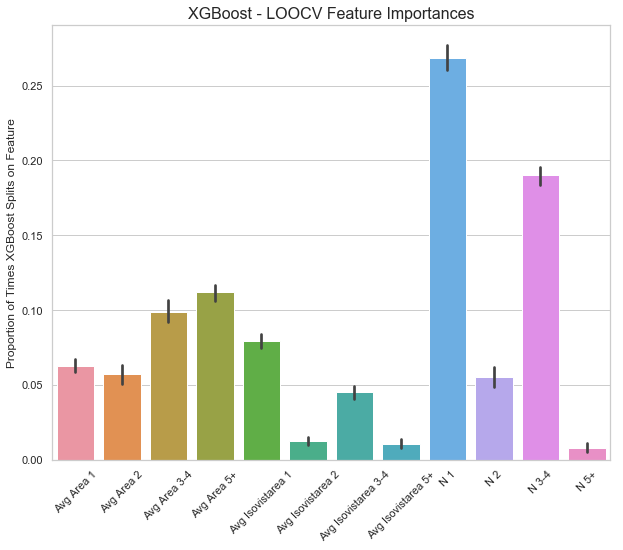

In [31]:
plot_df = pd.melt(feature_imp_df)

plt.rcParams['figure.figsize'] = 10, 8
sns.set(color_codes=sns.color_palette("coolwarm", 12))
sns.set_style("whitegrid")

sns.barplot(x='variable', y='value', data=plot_df, order=sorted(col_data[:-1]))
plt.xticks(range(len(col_data[:-1])), 
           map(lambda x: x.replace('_', ' ').title(), sorted(col_data[:-1])), 
           rotation=45)
plt.ylabel('Proportion of Times XGBoost Splits on Feature', fontsize=12)
plt.xlabel('')
plt.title('XGBoost - LOOCV Feature Importances', fontsize=16)
plt.show()

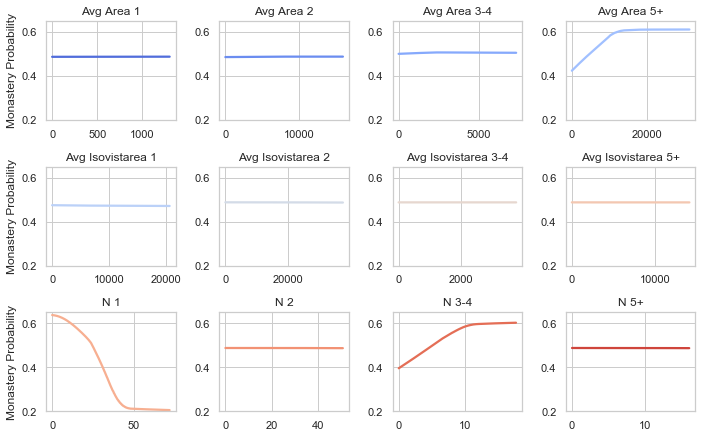

In [32]:
## One could also look at feature importances, but they should be avoided given the number of features

alpha_opacity = 0.001

number_of_columns = 4
number_of_rows = (len(feature_dep_plot_dict.keys()) / number_of_columns) + 1
number_of_subplots = len(feature_dep_plot_dict.keys())
color_palette = sns.color_palette("coolwarm", 12)

for j, feature in enumerate(sorted(col_data[:-1])):
    values = feature_dep_plot_dict[feature]
#for j, (feature, values) in enumerate(feature_dep_plot_dict.iteritems()):
    ax1 = plt.subplot(number_of_rows, number_of_columns, j + 1)
    sns.regplot(x=values['grid'], y=values['value'],scatter_kws={'alpha':alpha_opacity}, lowess=True, 
                color=color_palette[j])
    ax1.set_title(feature.replace('_', ' ').title())
    ax1.set_ylim([0.2,0.65])
    if (j+1) % number_of_columns == 1:
        ax1.set_ylabel('Monastery Probability')
plt.tight_layout()
plt.show()
    